[View in Colaboratory](https://colab.research.google.com/github/SwapnilSParkhe/FAST_AI/blob/master/FASTAI_Lesson1.ipynb)

#Fast.ai Course  
## Lesson-1: Image Classification - Cats Vs Dogs

### Step-0: Calibrate platforms (Setting-up compatibile interface btwn Colab & fast.ai) 

**Check if GPU running**

In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

**Installing required and dependent libraries on Colab for fast.ai**

In [0]:
#FASTAI lib (use this to remove '!rm -rf fastai')
!pip install fastai

#FASTAI dependencies - Pytorch & LibSim libs
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

#Others libs - Pillow, PIL, Image - For image
!pip install Pillow==4.0.0
!pip install image
import cv2
from os import path

#IMPORTANT STUFF - to enable smooth runs without memory issues
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

### Step-1: Importing relevant libraries and modules for analysis

In [0]:
#Library and modules
from fastai.imports import *   #main library
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

#To get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Step-2: Download dataset

In [0]:
#Making directory 'data' -> getting our data from the web ->unzipping zipped data to 'data' dir
!mkdir data && wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data/

### Step-3: Inspect data (and wrangle if required)

**Checking Directory Contents**

In [4]:
#Defining the sub-dir path
PATH = "data/dogscats"

#What folders/files do we have in sub-dir
!ls {PATH}
!ls {PATH}/valid
files = !ls {PATH}/valid/cats | head
files

models	sample	test1  train  valid
cats  dogs


['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

**Checking some data**

(299, 341, 3)

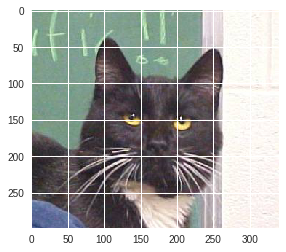

In [15]:
#Using plt's commands to read (path) and show image
##Note: Using Python string formating options f'{python_objects_or_funtions}'
img=plt.imread(f'{PATH}/valid/cats/{files[8]}')
plt.imshow(img)

#Dimensions of image - height vs width
img.shape

**Importing data and creating data-model pipeline**

In [0]:
#Creating an image classifier data object using a fastai defined class (that points to folder having images and in parallel applying transformations)
data=ImageClassifierData.from_paths(path=PATH, bs=32, tfms=tfms_from_model(resnet34,224))  


### Step-4: Train Model 
Note: 
  1. First, using transfer learning to leverage a pre-trained 'resnet34' model
  2. Later, we could fine tune the pre-trained model appropriately to achieve better results

In [5]:
#Creating a learner object using a fastai defined class (that leverages predefined convnet models)
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

#Fitting the learner object (having learning rate and epochs as arguments)
learn.fit(0.01,3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 44786639.58it/s]


100%|██████████| 63/63 [00:15<00:00,  3.97it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.054004   0.032513   0.986     
 39%|███▊      | 278/719 [00:06<00:10, 40.19it/s, loss=0.0691]

    1      0.062124   0.033558   0.989     
 79%|███████▉  | 568/719 [00:13<00:03, 40.57it/s, loss=0.0404]

    2      0.062472   0.025068   0.992     



[array([0.02507]), 0.992]

### Step-5: Analytise Results (to see where we failed, & focus there to further improve)
Note: As well as looking at the overall metrics, looking at examples of each of:

  1. A few correct labels at random (TP, TN)
  2. A few incorrect labels at random (FN, FP)
  3. The most correct labels of each class (High prob of TP and TN)
  4. The most incorrect labels of each class (High prob of FP and FN)
  5. The most uncertain labels (0.5 prob of TP or FP, and TN or FN)

**Predictions**

In [34]:
#Predicitons' Key (Actual 0 means cats, and vice-versa)
print(data.val_y)
print(data.classes,'\n')

#Predictions (Note: by default they are log preds in PyTorch)
log_preds=learn.predict()
print(log_preds)
print(log_preds.shape,'\n')

#Prediction class (and probability) - using '1' as the class of interest
preds=np.argmax(log_preds, axis=1)
probs=np.exp(log_preds[:,1])
print(preds)
print(probs)

[0 0 0 ... 1 1 1]
['cats', 'dogs'] 

[[ -0.0002   -8.51681]
 [ -0.00022  -8.40591]
 [ -0.01054  -4.5578 ]
 ...
 [ -7.73322  -0.00044]
 [-10.05474  -0.00004]
 [ -4.64123  -0.00969]]
(2000, 2) 

[0 0 0 ... 1 1 1]
[0.0002  0.00022 0.01049 ... 0.99956 0.99996 0.99035]


**Utility functions to analyse and visualise results**

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)
  
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+'/'+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))
  
  
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Correctly classified


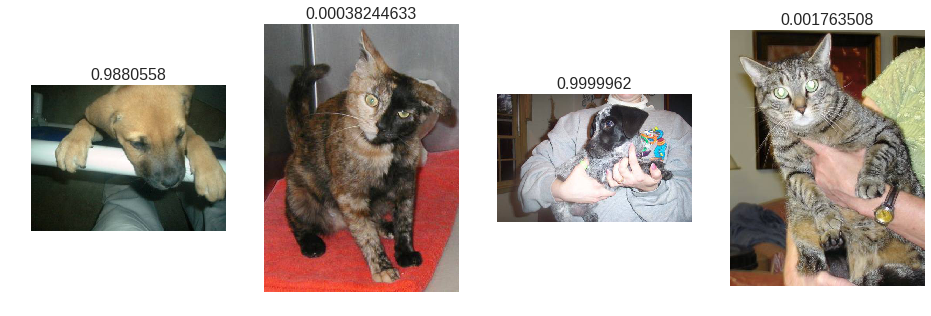

In [88]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


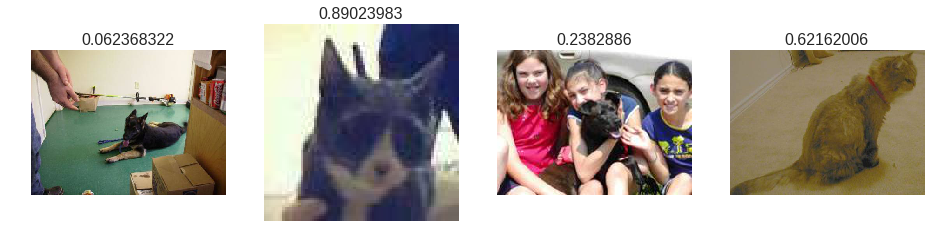

In [90]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Analysis (incorrect labels at random):
  - Not actually any animal w.r.t training
  - Too small image may be (creating an illusion)
  - Two distinct animals (class of interest is there, although on left whereas cat is at center)
  - Multiple figures creating an illusion may be, and class figure is too small

Most correct cats
Most correct dogs


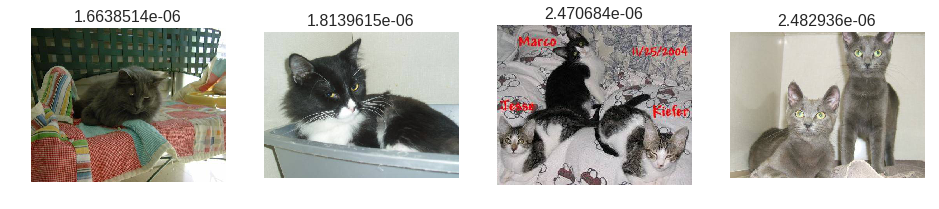

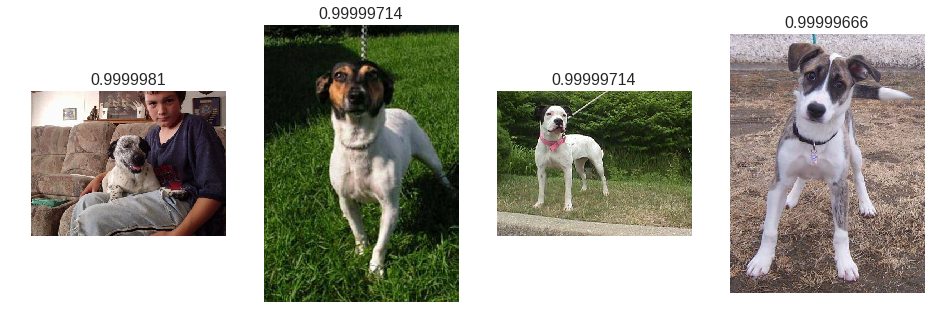

In [91]:
#3. Most Correct of each class
plot_val_with_title(most_by_correct(0, True), "Most correct cats")
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Analysis (most correct):
  - Class(s) usually lie at center
  - Class dominates major portion of image
  - Multiple elements of same class perform well
  - Optimal size of class element

Most incorrect cats
Most incorrect dogs


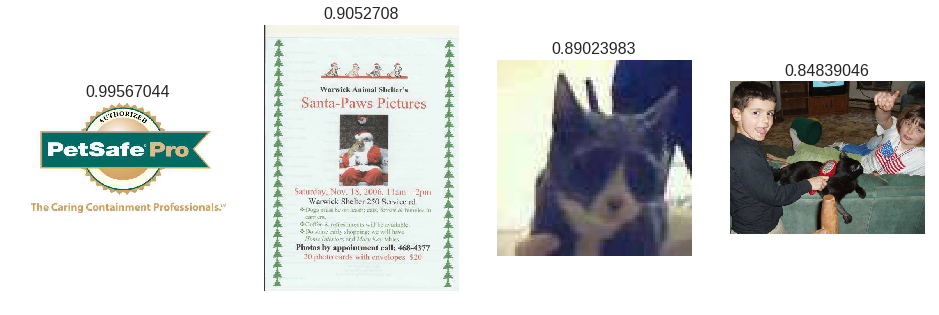

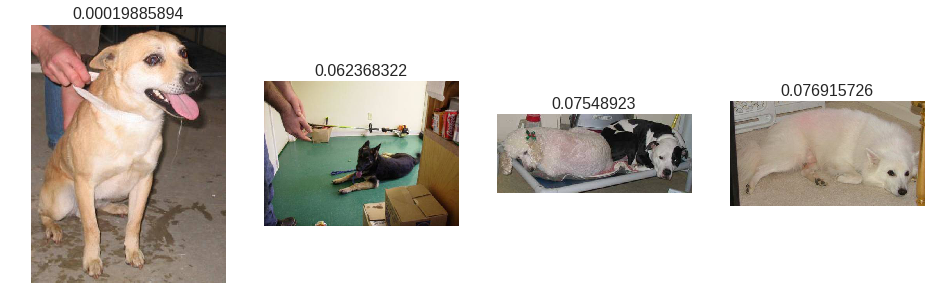

In [92]:
#4. Most Incorrect of each class
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Analysis (most incorrect):
  - Definately not any class
  - Pixels or image quality too bad
  - Multiple classes (not trained upon)
  - Zoomed in, Too wide or long images

Most uncertain predictions


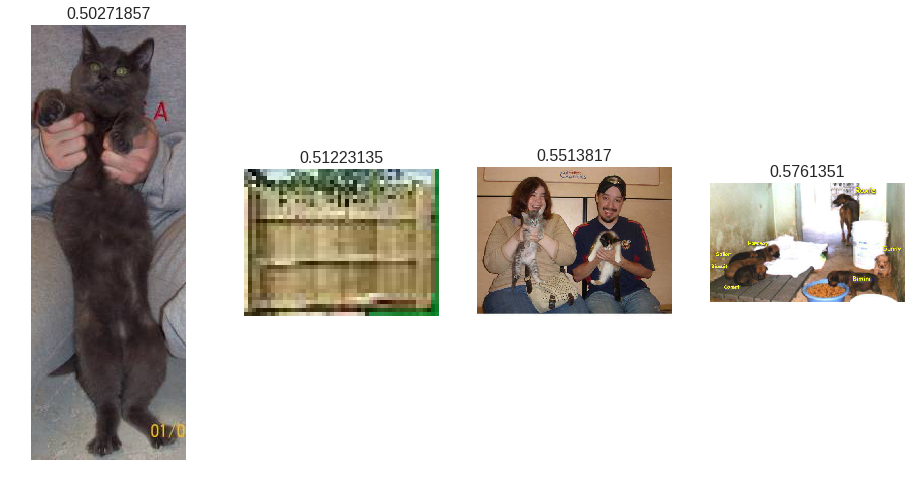

In [93]:
#5. Most uncertain
plot_val_with_title(np.argsort(np.abs(probs -0.5))[:4], "Most uncertain predictions")

Analysis:
  - Too long or wide (center of image must be well-defined)
  - Blurry and not relevant image
  - Multiple classes (of non-relevance)
  - Multiple classes of relevance but spread out (nothing at center)